# Mill-level attribution research and design

In [1]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from shapely.geometry import Point, mapping

import descarteslabs as dl
import descarteslabs.workflows as wf
from descarteslabs.client.services.storage import Storage

import attribution_utils as utils
from attribution_utils import MillDistance

/opt/conda/lib/python3.7/site-packages/descarteslabs/common/workflows/arrow_serialization/context.py:57: FutureWarning: 'pyarrow.SerializationContext' is deprecated and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  serialization_context = pa.SerializationContext()
/opt/conda/lib/python3.7/site-packages/descarteslabs/common/workflows/arrow_serialization/context.py:58: FutureWarning: 'pyarrow.register_default_serialization_handlers' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  pa.register_default_serialization_handlers(serialization_context)


In [2]:
# Version of the analysis
version = 1

# Define the buffer to be created around the mill in degrees (0.1 ~10k)
buffer = 0.25

# List of DL Products used here
composite_id = "descarteslabs:forest_carbon:S2_GEDI:composite:v1.1"
deforestation_id = "descarteslabs:ul_deforestation_external_v3"
forest_carbon_id = "descarteslabs:GEDI:TCH:ForestCarbon:final:v2.1"
palm_mask_id = "descarteslabs:unilever-palm-classification-v3"

# Font sizes to use
ftitle = 20
flabel = 18

## 1. Calculating statistics on deforestation and carbon lost per mill

### 1.1. Overview of the methodology (see also `attribution_utils.py`)

In [3]:
# Create the buffer around one mill
lat, lon = 3.294139, 102.821528
geometry = Point(lon, lat).buffer(buffer)

# AOI definitions
resolution = 30  # m
aoi = dl.scenes.AOI(geometry=mapping(geometry), resolution=resolution)
pixel_area = resolution * resolution
m2_to_ha = 0.0001

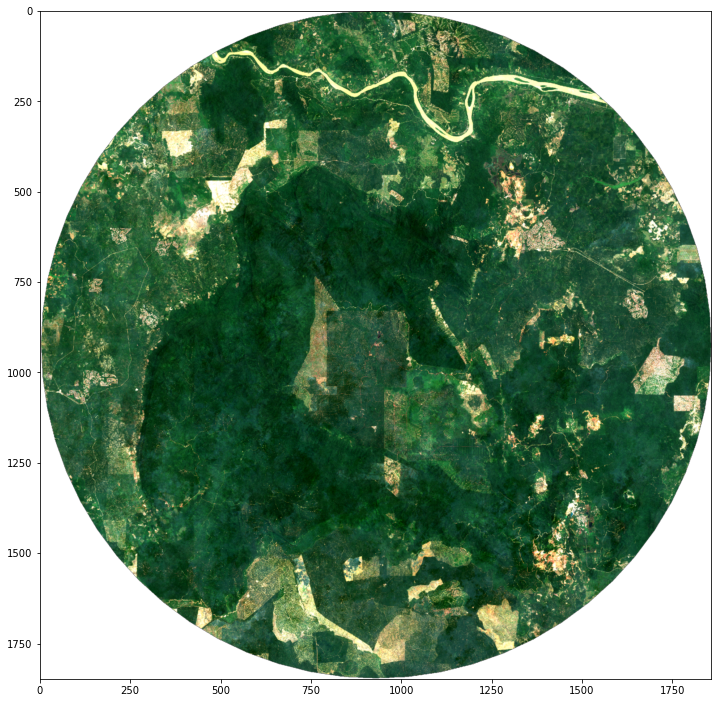

In [4]:
# Load Sentinel-2 Composite
scenes, ctx = dl.scenes.search(
    aoi,
    products=composite_id,
    start_datetime="2015-01-01",
    end_datetime="2020-12-01",
    limit=500,
)
s2_composite = scenes.mosaic("red green blue", ctx)

dl.scenes.display(s2_composite)

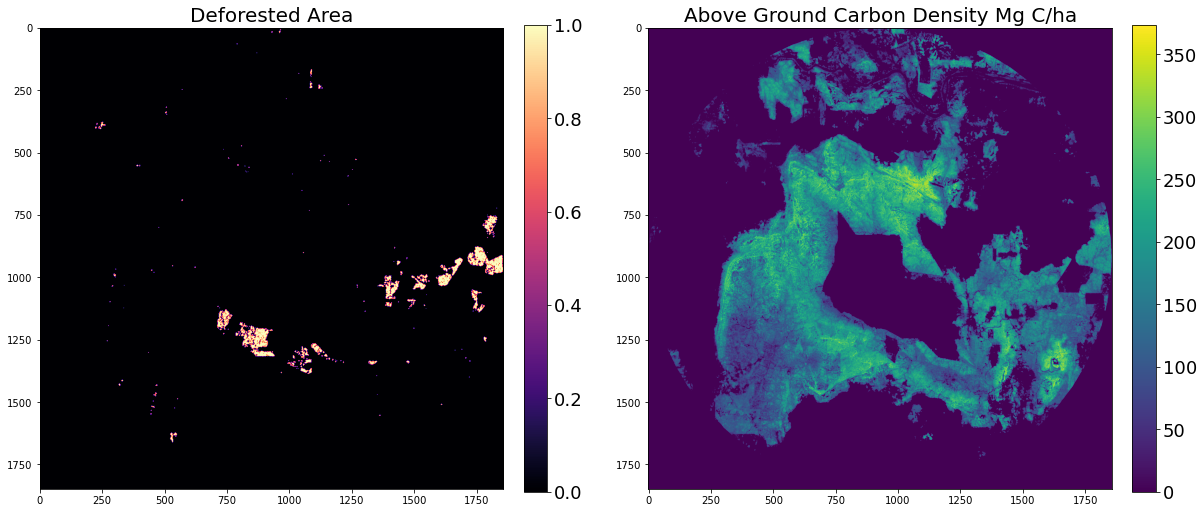

In [6]:
# Load the deforestation and forest carbon over the AOI
acd, defor = utils.regional_maps(aoi)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
im = plt.imshow(defor, cmap = "magma")
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=flabel) 
plt.title("Deforested Area", fontsize=ftitle)

plt.subplot(1,2,2)
im = plt.imshow(acd/pixel_area/m2_to_ha)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=flabel) 
plt.title("Above Ground Carbon Density Mg C/ha", fontsize=ftitle)
plt.show()

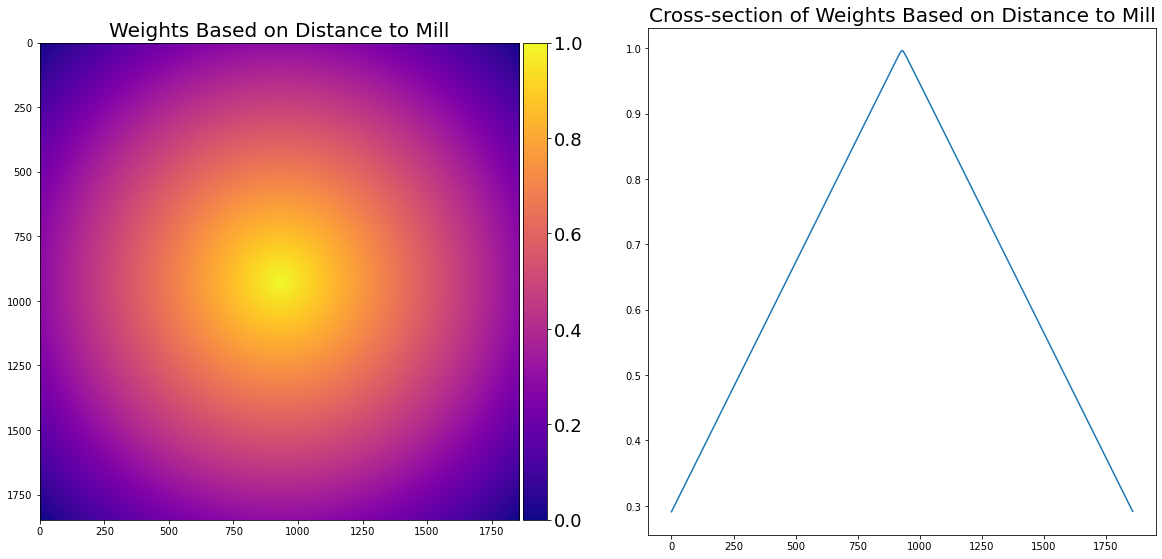

In [6]:
# Load the weights we'll use
weights = utils.get_spatial_weights(*acd.shape)
weights_1d = weights[round(weights.shape[1]/2.),:]

# Plot
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(20,20))

im = ax.imshow(weights, cmap = "plasma")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.tick_params(labelsize=flabel)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title("Weights Based on Distance to Mill", fontsize=ftitle)

ax2.plot(weights_1d)
ax2.set_title("Cross-section of Weights Based on Distance to Mill", fontsize=ftitle)

asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

plt.show()

In [7]:
# Count the total area deforested (ha)
total_defor_area = np.sum(defor) * pixel_area * m2_to_ha
    
# Count the total forest carbon lost (Mg C)
total_defor_carbon = np.sum(acd[defor > 0])

# Maximum weighted average of carbon lost if all area was deforested (Mg C)
max_carbon = np.average(acd, weights=weights)

# Maximum weighted average of deforested area if all area was deforested (ha)
forest_mask = np.array(acd[:])
forest_mask[forest_mask > 0] = 1
max_area = np.average(forest_mask * pixel_area * m2_to_ha, weights=weights)

# Weighted average of forest carbon lost (Mg C)
defor_carbon = np.array(acd[:])
defor_carbon[defor == 0] = 0
defor_carbon_mean = np.average(defor_carbon, weights=weights)

# Weighted average of deforested area (ha)
defor_area_mean = np.average(defor * pixel_area * m2_to_ha, weights=weights)

# Percentage of maximum forest carbon lost and deforested area
carbon_score = 100 * defor_carbon_mean / max_carbon
area_score = 100 * defor_area_mean / max_area

print("Total deforested area: {} ha".format(total_defor_area))
print("Total forest carbon lost: {} Mg C".format(total_defor_carbon))
print("Area Score: {}".format(area_score))
print("Carbon Score: {}".format(carbon_score))

Total deforested area: 3355.4700000000003 ha
Total forest carbon lost: 575478.1009048223 Mg C
Area Score: 2.9052965206410772
Carbon Score: 3.273420244347844


### 1.2. Now deploy for the Universal Mill List

#### Load Universal Mill List over Indonesia and Malaysia

In [8]:
# Load table and filter for mills in Indonesia and Malaysia
df_uml = pd.read_csv("Universal_Mill_List.csv")
df_uml = df_uml[(df_uml["Country"]=="Indonesia") | (df_uml["Country"]=="Malaysia")]
print("Total number of mills: {}".format(len(df_uml.index)))

# Get the coordinates of the mills
lons = df_uml.X.values
lats = df_uml.Y.values
mill_ids = df_uml.UML_ID.values

Total number of mills: 1661


#### Calculate statistics for each mill
This only needs to be run once since the results are saved to DL Storage

In [9]:
# # Create arguments
# task_args = [[lats[i], lons[i], mill_ids[i], buffer, version] for i in range(len(lats))]

# run_tasks = True
# if run_tasks:

#     # Create Tasks function
#     docker_image = "us.gcr.io/dl-ci-cd/images/tasks/public/py3.7:v2021.03.03-6-g160ae345"
#     async_func = dl.tasks.create_function(
#         "attribution_utils.calculate_scores_per_mill",
#         name="mill_attribution",
#         image=docker_image,
#         memory="11Gi",
#         retry_count=2,
#         maximum_concurrency=100,
#         include_modules=["attribution_utils"],
#         )

#     # Deploy Tasks
#     tasks = async_func.map(task_args)

In [10]:
# run_check = False
# if run_check:
    
#     # Get results stored in DL Storage
#     storage_keys = list(Storage().iter_list(prefix="mill_stats_mvp_v{}".format(version)))
#     nmills = len(storage_keys)
    
#     all_keys = list(map(lambda i: "mill_stats_mvp_v{}_{}_{}".format(version, lats[i], lons[i]), range(len(lons))))
#     missing = list(set(all_keys).difference(set(storage_keys)))
#     missing_task_args = list(map(lambda i: task_args[all_keys.index(missing[i])], range(len(missing))))
#     print("{} missing mills.".format(len(missing_task_args)))

#     if len(missing_task_args) > 0:
        
#         # Create Tasks function
#         docker_image = "us.gcr.io/dl-ci-cd/images/tasks/public/py3.7:v2021.03.03-6-g160ae345"
#         async_func = dl.tasks.create_function(
#             "attribution_utils.calculate_scores_per_mill",
#             name="mill_attribution",
#             image=docker_image,
#             memory="11Gi",
#             retry_count=2,
#             maximum_concurrency=100,
#             include_modules=["attribution_utils"],
#             )

#         # Deploy Tasks
#         tasks_rerun = async_func.map(missing_task_args)

#### Aggregate results from DL Storage

In [13]:
gdf = utils.get_df_from_results(version)
gdf.head()

Number of mills processed: 1653


,lat,lon,mill_id,total_deforested_area,total_carbon_lost,area_score,carbon_score,geometry
0,-0.002078,102.196417,PO1000007596,18.99,1370904.4,0.119452,0.103455,POINT (102.196417 -0.002078)
1,-0.020750,109.546200,PO1000004856,56.52,5966502.0,0.077184,0.128769,POINT (109.5462 -0.02075)
2,-0.022183,109.424883,PO1000004335,14.85,1109725.8,0.030529,0.034538,POINT (109.424883 -0.022183)
3,-0.027090,100.002981,PO1000007589,116.82,20488476.0,0.085658,0.092091,POINT (100.002981 -0.02709)
4,-0.028740,110.454143,PO1000007586,587.61,64250892.0,0.406529,0.462622,POINT (110.454143 -0.02874)


#### Quick visualizations

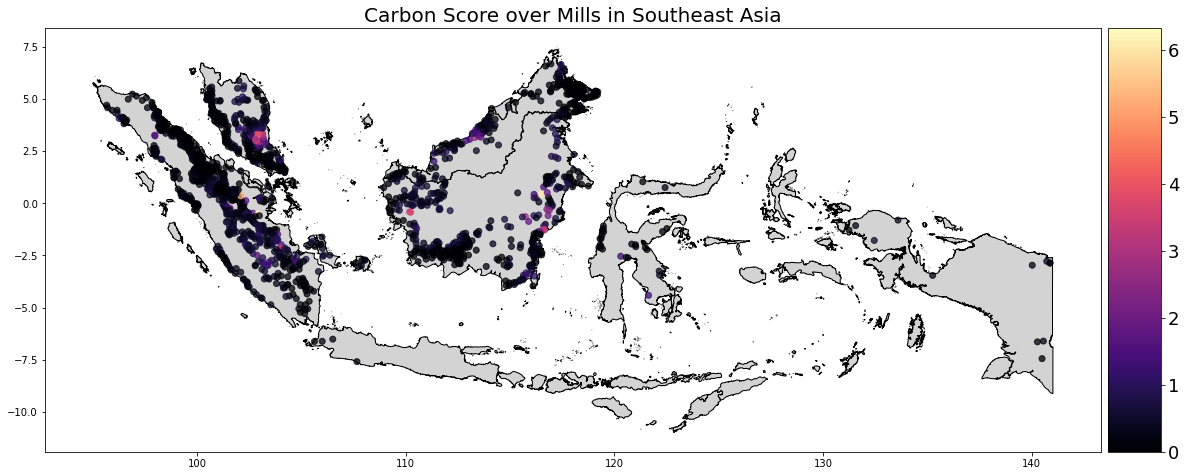

In [14]:
se_asia = gpd.read_file("indonesia_and_malaysia.geojson")

fig, ax = plt.subplots(1, 1, figsize=(20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
base = se_asia.plot(color='lightgray', edgecolor='black', ax=ax)
gdf.plot(column="carbon_score", cmap="magma", ax=base, legend=True, cax=cax, alpha=0.75)
ax.set_title('Carbon Score over Mills in Southeast Asia', fontsize=ftitle)
cax.tick_params(labelsize=flabel)

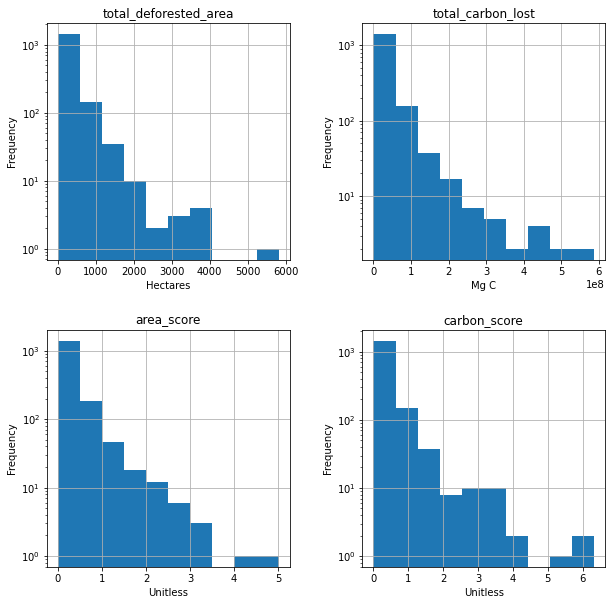

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
gdf.hist(column="total_deforested_area", ax=ax[0][0], log=True)
ax[0][0].set_xlabel("Hectares"); ax[0][0].set_ylabel("Frequency")

gdf.hist(column="total_carbon_lost", ax=ax[0][1], log=True)
ax[0][1].set_xlabel("Mg C"); ax[0][1].set_ylabel("Frequency")

gdf.hist(column="area_score", ax=ax[1][0], log=True)
ax[1][0].set_xlabel("Unitless"); ax[1][0].set_ylabel("Frequency")

gdf.hist(column="carbon_score", ax=ax[1][1], log=True)
ax[1][1].set_xlabel("Unitless"); ax[1][1].set_ylabel("Frequency")
plt.show()

### 1.3. Visualize results using DL Workflows

#### Create raster layer of scores on carbon lost and deforested area for each mill

In [16]:
lons = gdf.lon.values
lats = gdf.lat.values
carbon_scores = gdf.carbon_score.values
area_scores = gdf.area_score.values
buffer_image = 0.05

raster_carbon_score = utils.get_wf_raster_layer(lons, lats, carbon_scores, buffer_image)
area_carbon_score = utils.get_wf_raster_layer(lons, lats, carbon_scores, buffer_image)

#### Add a few other interesting layers

In [17]:
# Load Sentinel 2 composite
s2_ic = (wf.ImageCollection.from_id(composite_id,
                                    start_datetime="2015-01-01",
                                    end_datetime="2020-12-01",
                                    resampler="near")
                    .mosaic())
s2_composite = s2_ic.pick_bands("red green blue")

# Get Descartes Labs' forest carbon density product
dl_forest_carbon = (wf.ImageCollection.from_id(forest_carbon_id,
                                               start_datetime='2019-01-01',
                                               end_datetime='2020-12-31',
                                               resampler='near')
                    .mosaic())
dl_acd = dl_forest_carbon.pick_bands(["acd_tons"])
dl_acd = dl_acd.mask(dl_acd==0)

# Load Descartes Labs' deforestation product
deforestation_start = "2020-07-01"
deforestation_end = "2020-12-31"
defor_ic = (wf.ImageCollection.from_id(deforestation_id,
                                       start_datetime=deforestation_start,
                                       end_datetime=deforestation_end,
                                       resampler='near')
            .max(axis='images'))
detections = defor_ic.pick_bands("detection_date")
dl_deforestation = detections.mask(detections==0)

# Load Palm mask for 2020
dl_palm = (wf.ImageCollection.from_id(palm_mask_id,
                                      start_datetime='2020-01-01',
                                      end_datetime='2021-12-31',
                                      resampler='near')
                    .mosaic())
dl_palm = dl_palm.pick_bands(["class"])
dl_palm = dl_palm.mask(dl_palm==0)

In [18]:
# Visualize all layers together
s2_composite.visualize('S2 Composite (2020)', scales=[[0, 1400], [0, 1400], [0, 1400]])
dl_acd.visualize('DL Forest Carbon (2019-2020)', checkerboard=False, scales=[0,30], colormap="viridis")
dl_deforestation.visualize("DL Deforestation", colormap = 'magma', checkerboard=False)
dl_palm.visualize("DL Palm (2020)", colormap = 'Purples', checkerboard=False)
raster_carbon_score.visualize('Mill Carbon Score', colormap = 'plasma', scales=[0,5])
raster_carbon_score.visualize('Mill Defor Area Score', colormap = 'magma', scales=[0,5])

In [19]:
m=wf.map
m.map.center = 3.294139, 102.821528 #-0.4784, 116.5319
wf.map.zoom = 11
m


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


## 2. Identify mills around specific palm plantations

### 2.1. Example for one location

In [ ]:
# Get the Shapely point for the current palm plantation
lat_palm, lon_palm = 3.2844, 102.8145
palm_plantation = Point(lon_palm, lat_palm)

# Calculate the distances to each mill in the Universal Mill List and add it to a duplicated geopandas dataframe
dists = list(map(lambda i: gdf["geometry"][i].distance(palm_plantation), range(gdf.shape[0])))
gdf_palm = gdf.copy()
gdf_palm["dist_to_plantation"] = dists

# Sort to find the closest mills
gdf_palm = gdf_palm.sort_values(by=['dist_to_plantation'], ignore_index=True)

In [ ]:
# Look at the five closest mills
gdf_palm.head()

### 2.2. Replicate for regions selected on `wf.map`

In [ ]:
palm_map_results = MillDistance(m)
MillDistance.get_arguments(palm_map_results, gdf)

#### Warning: Make sure you click on a point on the map or draw a polygon before proceeding

In [ ]:
gdf_palm_map = palm_map_results.df
gdf_palm_map.head()

## Draft code

In [ ]:
# Load Palm mask over the given area
palm_wf = dl_palm.compute(wf.map.geocontext())
palm_wf = palm_wf.ndarray.squeeze()

In [ ]:
# Dilate and erode to get a more homegeneous field
from scipy.ndimage.morphology import binary_dilation, binary_erosion, generate_binary_structure
struct = generate_binary_structure(2,1)
print(struct)

temp = binary_erosion(palm_wf, structure=struct)
temp = binary_dilation(temp, structure=struct)

In [ ]:
#plt.figure(figsize=(20,20))
plt.subplot(2,1,1); plt.imshow(palm_wf); plt.colorbar()
plt.subplot(2,1,2); plt.imshow(temp); plt.colorbar()